In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns

In [3]:
BATCH_SIZE = 15
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\omhee\Downloads\cow-disease (3)\cow-disease"

,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2582 files belonging to 5 classes.


In [7]:
class_names=dataset.class_names
class_names

['cows_Mange', 'cows_pox', 'cows_ringworm', 'healthycows', 'lumpycows']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(15, 256, 256, 3)
[4 2 2 4 3 2 3 2 0 2 4 3 4 4 2]


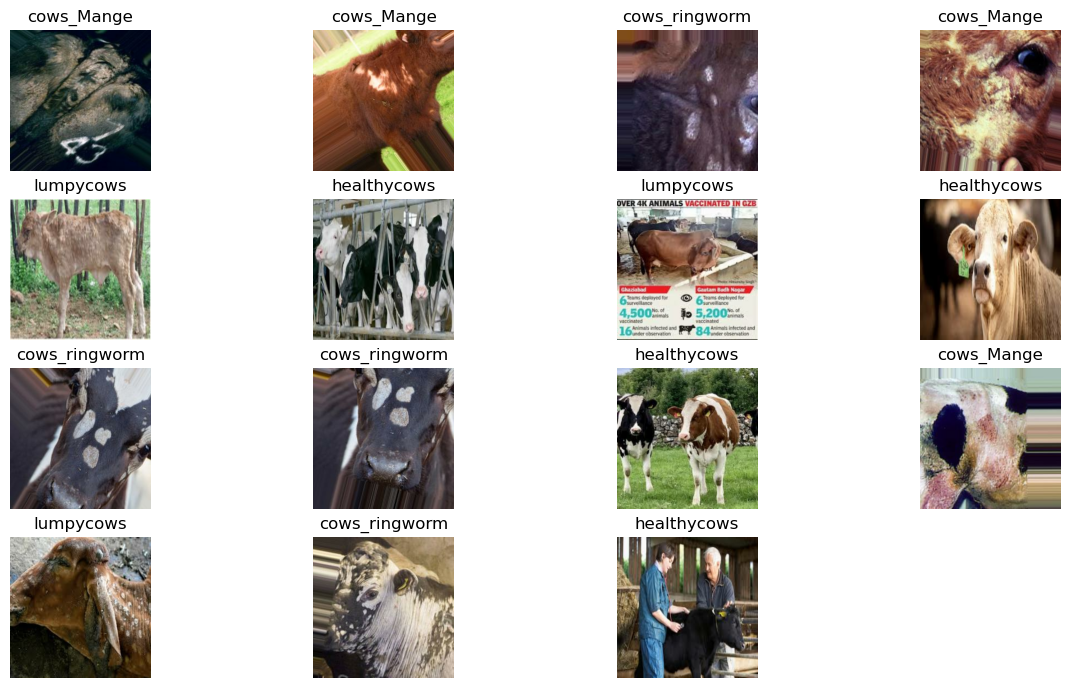

In [9]:
plt.figure(figsize=(15, 15))
num_rows = (BATCH_SIZE + 15) // 4  # Calculate the number of rows based on BATCH_SIZE
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(num_rows, 4, i + 1)  # Dynamically set the number of rows and columns
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [10]:
len(dataset)

173

(<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[10., 40., 38.],
        [11., 41., 39.],
        [12., 42., 40.],
        ...,
        [ 1.,  6., 26.],
        [ 0.,  5., 25.],
        [ 0.,  5., 25.]],

       [[14., 44., 42.],
        [13., 43., 41.],
        [11., 41., 39.],
        ...,
        [ 1.,  6., 26.],
        [ 1.,  6., 26.],
        [ 0.,  5., 25.]],

       [[20., 50., 48.],
        [17., 47., 45.],
        [13., 43., 41.],
        ...,
        [ 1.,  6., 26.],
        [ 1.,  6., 26.],
        [ 1.,  6., 26.]],

       ...,

       [[ 9., 18., 27.],
        [16., 25., 32.],
        [25., 34., 41.],
        ...,
        [ 0., 10., 16.],
        [ 0., 10., 16.],
        [ 0., 10., 16.]],

       [[21., 30., 37.],
        [22., 31., 36.],
        [22., 31., 36.],
        ...,
        [ 0., 10., 16.],
        [ 0.,  9., 15.],
        [ 0.,  9., 15.]],

       [[32., 41., 46.],
        [26., 35., 40.],
        [17., 26., 31.],
        ...,
        [ 0., 10.,

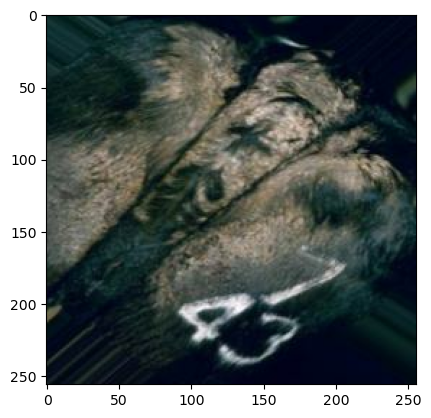

In [11]:
for x in dataset.unbatch():
    plt.imshow(x[0]/255)
    print(x)
    break

In [12]:
train=0.8

In [13]:
df_test=dataset.skip(18)
val_df=df_test

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_df,val_df,test_df=get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_df.map(lambda x, y: (x, tf.one_hot(y, len(class_names))))
val_ds = val_df.map(lambda x, y: (x, tf.one_hot(y, len(class_names))))
test_ds = test_df.map(lambda x, y: (x, tf.one_hot(y, len(class_names))))

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.25),
    layers.experimental.preprocessing.RandomZoom((0.5,0.2)),
    layers.experimental.preprocessing.RandomZoom((-0.7,-0.2)),
    layers.experimental.preprocessing.RandomContrast(factor=0.1)
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)
output_units = len(class_names)
output_activation = 'softmax'  # Ensure softmax activation for multi-class classification
model = models.Sequential([
    resize_and_rescale,
    #data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),  # Hidden Layer
    layers.Dense(output_units, activation=output_activation) 
])

model.build(input_shape=input_shape)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20


138/138 [==============================] - 124s 769ms/step - loss: 1.5440 - accuracy: 0.2771 - val_loss: 1.4201 - val_accuracy: 0.3451
Epoch 2/20
138/138 [==============================] - 103s 721ms/step - loss: 1.3356 - accuracy: 0.3933 - val_loss: 1.1695 - val_accuracy: 0.5216
Epoch 3/20
138/138 [==============================] - 100s 705ms/step - loss: 1.2685 - accuracy: 0.4473 - val_loss: 1.2426 - val_accuracy: 0.4549
Epoch 4/20
138/138 [==============================] - 101s 718ms/step - loss: 1.1859 - accuracy: 0.5105 - val_loss: 1.4219 - val_accuracy: 0.3843
Epoch 5/20
138/138 [==============================] - 102s 721ms/step - loss: 1.1175 - accuracy: 0.5591 - val_loss: 0.9383 - val_accuracy: 0.6694
Epoch 6/20
138/138 [==============================] - 100s 707ms/step - loss: 1.0433 - accuracy: 0.5980 - val_loss: 1.2020 - val_accuracy: 0.5647
Epoch 7/20
138/138 [==============================] - 99s 702ms/step - loss: 0.9995 - accuracy: 0.6014 - val_loss: 0.9118 

In [23]:
model.evaluate(test_ds)

18/18 [==============================] - 8s 167ms/step - loss: 0.5258 - accuracy: 0.7593


[0.5257695317268372, 0.7592592835426331]

In [24]:
def Predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    print(predictions)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class,confidence

C:\Users\omhee\AppData\Local\Temp\ipykernel_9044\524238864.py:29: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
C:\Users\omhee\AppData\Local\Temp\ipykernel_9044\524238864.py:39: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


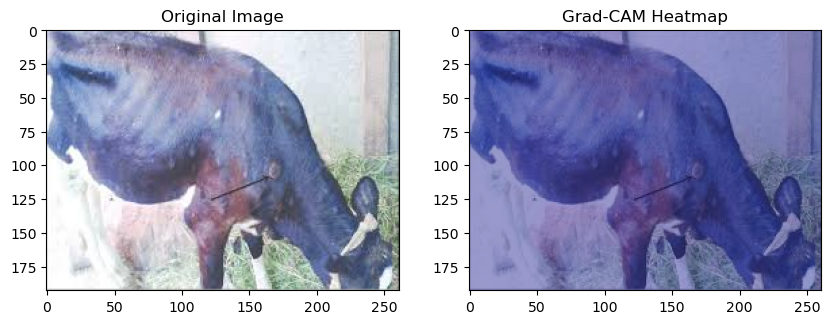

In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the pretrained model (e.g., VGG16)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

# Modify the model to include a global average pooling layer and a fully connected layer
last_conv_layer = base_model.get_layer('block5_conv3')  # Get the last convolutional layer
grad_model = Model(inputs=base_model.inputs, outputs=[base_model.get_layer('block5_pool').output, base_model.output])

# Define a function to compute the gradient-weighted class activation map (Grad-CAM)
def compute_grad_cam(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Resize the image
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.vgg16.preprocess_input(x)  # Preprocess the input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, np.argmax(predictions[0])]  # Compute the loss for the predicted class
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Load an example image and compute Grad-CAM
image_path = r"C:\Users\omhee\Downloads\cow-disease (3)\cow-disease\lumpycows\img1414.jpg"
heatmap = compute_grad_cam(image_path)

# Overlay the heatmap on the original image
img = cv2.imread(image_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Visualize the original image and Grad-CAM heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, ::-1])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img[:, :, ::-1])
plt.title('Grad-CAM Heatmap')
plt.show()


In [25]:
from PIL import Image
import os

def grayscale_images(main_folder_path, output_folder_path, class_names):
    for class_name in class_names:
        class_folder_path = os.path.join(main_folder_path, class_name)
        output_class_folder_path = os.path.join(output_folder_path, class_name)
        os.makedirs(output_class_folder_path, exist_ok=True)

        for filename in os.listdir(class_folder_path):
            if filename.endswith(".png") or filename.endswith(".jpg"):
                image_path = os.path.join(class_folder_path, filename)
                output_path = os.path.join(output_class_folder_path, filename)

                # Open the image using PIL
                img = Image.open(image_path)

                # Convert the image to grayscale
                grayscale_img = img.convert('L')

                # Save the grayscale image to the output folder
                grayscale_img.save(output_path)

                # Print the file name for demonstration
                print(f"Grayscaling and saving: {filename}")

if __name__ == "__main__":
    # Provide the path to the main folder containing subfolders with images for each class
    main_folder_path = r"C:\\Users\\omhee\\Downloads\\cow-disease\\cow-disease"

    # Provide the path to the output folder where grayscale images will be saved
    output_folder_path = "grayscale_images"

    # List of class names in your dataset
    class_names = ['cows_Mange', 'cows_pox', 'cows_ringworm', 'healthycows', 'lumpycows']

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder_path, exist_ok=True)

    # Call the function to grayscale images
    grayscale_images(main_folder_path, output_folder_path, class_names)


Grayscaling and saving: 00000000 (1).jpg
Grayscaling and saving: 00000000.jpg
Grayscaling and saving: 00000001 (1).jpg
Grayscaling and saving: 00000001.jpg
Grayscaling and saving: 00000002.jpg
Grayscaling and saving: 00000003.jpg
Grayscaling and saving: 00000004.jpg
Grayscaling and saving: 00000006 (1).jpg
Grayscaling and saving: 00000006.jpg
Grayscaling and saving: 00000007.jpg
Grayscaling and saving: 00000014.jpg
Grayscaling and saving: 00000060.jpg
Grayscaling and saving: 00000102.jpg
Grayscaling and saving: 00000110.jpg
Grayscaling and saving: 0 (1).jpg
Grayscaling and saving: 0 (2).jpg
Grayscaling and saving: 0 (3).jpg
Grayscaling and saving: 0 (4).jpg
Grayscaling and saving: 0 (5).jpg
Grayscaling and saving: 0 (6).jpg
Grayscaling and saving: 0 (7).jpg
Grayscaling and saving: 00000038 (1).jpg
Grayscaling and saving: 00000038.jpg
Grayscaling and saving: 40.jpg
Grayscaling and saving: 41.jpg
Grayscaling and saving: 42.jpg
Grayscaling and saving: 43.jpg
Grayscaling and saving: unname

In [26]:
model.save("CNN.h5")

C:\Users\omhee\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
from tensorflow import keras

# Load the saved model
model1 = keras.models.load_model('CNN.h5')

# Loop through the test dataset
for img, label in test_df.take(1):
    # Loop through each image in the batch
    for i in range(min(BATCH_SIZE, len(img))):  # Ensure i does not exceed the size of the img array
        # Convert the image to a numpy array
        img_array = tf.keras.preprocessing.image.img_to_array(img[i].numpy())
        img_array = tf.expand_dims(img_array, 0)
        
        # Make predictions using the loaded model
        predictions = model1.predict(img_array)
        
        # Print the predicted class and confidence
        print(class_names[np.argmax(predictions[0])], np.max(predictions[0]))


1/1 [==============================] - 1s 954ms/step
healthycows 0.627582
1/1 [==============================] - 0s 159ms/step
healthycows 0.9229795
1/1 [==============================] - 0s 65ms/step
cows_pox 0.8852989
1/1 [==============================] - 0s 52ms/step
healthycows 0.94456965
1/1 [==============================] - 0s 55ms/step
cows_pox 0.97532815
1/1 [==============================] - 0s 49ms/step
healthycows 0.87907845
1/1 [==============================] - 0s 71ms/step
cows_pox 0.99999976
1/1 [==============================] - 0s 56ms/step
lumpycows 0.5038719
1/1 [==============================] - 0s 45ms/step
cows_Mange 0.91792953
1/1 [==============================] - 0s 48ms/step
cows_ringworm 0.65877223
1/1 [==============================] - 0s 61ms/step
healthycows 0.85228616
1/1 [==============================] - 0s 46ms/step
cows_ringworm 0.8802318
1/1 [==============================] - 0s 43ms/step
cows_ringworm 0.88841707
1/1 [==============================

In [46]:
from tensorflow import keras
model1 = keras.models.load_model('CNN.h5')
for img,label in test_df.take(1):
    for i in range(BATCH_SIZE):
        img_array=tf.keras.preprocessing.image.img_to_array(img[i].numpy())
        img_array=tf.expand_dims(img_array,0)
        predictions = model1.predict(img_array)
        print(class_names[np.argmax(predictions[0])],np.max(predictions[0]))

1/1 [==============================] - 0s 83ms/step
healthycows 0.86875004
1/1 [==============================] - 0s 22ms/step
healthycows 0.5063026
1/1 [==============================] - 0s 21ms/step
lumpycows 0.55780876
1/1 [==============================] - 0s 22ms/step
healthycows 0.84605104
1/1 [==============================] - 0s 21ms/step
healthycows 0.6005194
1/1 [==============================] - 0s 23ms/step
healthycows 0.96271926
1/1 [==============================] - 0s 21ms/step
healthycows 0.49449486
1/1 [==============================] - 0s 21ms/step
lumpycows 0.5542133
1/1 [==============================] - 0s 21ms/step
healthycows 0.7959889
1/1 [==============================] - 0s 21ms/step
healthycows 0.85513514
1/1 [==============================] - 0s 20ms/step
healthycows 0.84857684
1/1 [==============================] - 0s 22ms/step
healthycows 0.79614973
1/1 [==============================] - 0s 22ms/step
lumpycows 0.7704259
1/1 [==============================]

1/1 [==============================] - 0s 455ms/step
[[6.8101183e-02 3.8631292e-06 5.0716698e-01 2.8369698e-01 1.4103101e-01]]
1/1 [==============================] - 0s 118ms/step
[[2.9972057e-06 9.9200082e-01 1.2662680e-03 2.7735028e-03 3.9564781e-03]]
1/1 [==============================] - 0s 129ms/step
[[1.1044971e-14 9.9997842e-01 9.5556870e-06 8.5948423e-06 3.4546608e-06]]
1/1 [==============================] - 0s 65ms/step
[[3.1457291e-04 5.2629897e-05 9.2803169e-04 8.8879949e-01 1.0990524e-01]]
1/1 [==============================] - 0s 46ms/step
[[3.5767383e-07 1.3612852e-06 8.4126259e-06 8.8721305e-01 1.1277680e-01]]
1/1 [==============================] - 0s 44ms/step
[[8.8881749e-01 4.7707651e-08 6.0948305e-02 1.9549256e-02 3.0684831e-02]]
1/1 [==============================] - 0s 61ms/step
[[3.7244131e-08 9.9395919e-01 5.0914907e-03 3.8502432e-04 5.6428532e-04]]
1/1 [==============================] - 0s 92ms/step
[[4.1955454e-06 6.7513138e-06 1.4679598e-04 8.8805187e-01 1.117

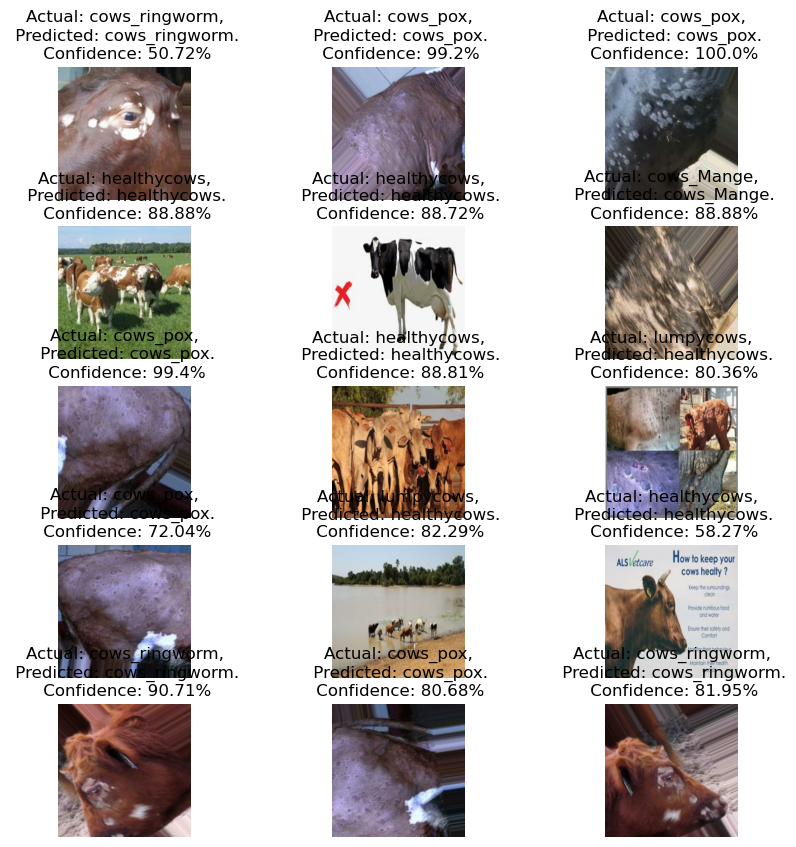

In [28]:
import numpy as np

# Calculate the number of rows and columns for subplots dynamically
num_rows = int(np.ceil(BATCH_SIZE / 3))
num_cols = min(BATCH_SIZE, 3)

plt.figure(figsize=(10, 10))
for img, label in test_df.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        pred, conf = Predict(model, img[i].numpy())
        actual_class = class_names[label[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {pred}.\n Confidence: {conf}%")
        plt.axis("off")


In [31]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler

# Function to load cow disease images and corresponding labels
def load_images_and_labels(data_folder, batch_size=100):
    images = []
    labels = []

    class_labels = ['cows_Mange', 'cows_pox', 'cows_ringworm', 'healthycows', 'lumpycows']

    for label in class_labels:
        folder_path = os.path.join(data_folder, label)
        if os.path.isdir(folder_path):
            image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
            num_batches = len(image_files) // batch_size
            for i in range(num_batches):
                batch_files = image_files[i * batch_size: (i + 1) * batch_size]
                batch_images = []
                for image_file in batch_files:
                    image_path = os.path.join(folder_path, image_file)
                    image = io.imread(image_path)
                    image = resize(image, (64, 64))  # Adjust dimensions as needed
                    batch_images.append(image.flatten())
                images.extend(batch_images)
                labels.extend([label] * len(batch_images))

    return np.array(images), np.array(labels)

# Set your data folder path
data_folder = "grayscale_images"

# Load cow disease images and labels
X, y = load_images_and_labels(data_folder)

# Define the percentages for splitting the dataset
split_percentages = [0.2, 0.4, 0.6, 0.8]

# Loop over different split percentages
for i, split_percentage in enumerate(split_percentages):
    print(f"Experiment {i+1}:")
    
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - split_percentage, random_state=0)

    # Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Training the MLP classifier
    classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
    classifier.fit(X_train, y_train)

    # Making predictions
    y_pred = classifier.predict(X_test)

    # Evaluating the model
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("---------------------------------------")


Experiment 1:
[[196 203]
 [139 182]]
              precision    recall  f1-score   support

 healthycows       0.59      0.49      0.53       399
   lumpycows       0.47      0.57      0.52       321

    accuracy                           0.53       720
   macro avg       0.53      0.53      0.52       720
weighted avg       0.53      0.53      0.53       720

---------------------------------------
Experiment 2:
[[180 127]
 [107 126]]
              precision    recall  f1-score   support

 healthycows       0.63      0.59      0.61       307
   lumpycows       0.50      0.54      0.52       233

    accuracy                           0.57       540
   macro avg       0.56      0.56      0.56       540
weighted avg       0.57      0.57      0.57       540

---------------------------------------
Experiment 3:
[[128  78]
 [ 72  82]]
              precision    recall  f1-score   support

 healthycows       0.64      0.62      0.63       206
   lumpycows       0.51      0.53      0.52   

In [32]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

# Function to load and preprocess image data
def load_images_and_labels(data_directory):
    images = []
    labels = []
    label_map = {}  # Dictionary to map folder names to class labels
    
    for i, folder_name in enumerate(os.listdir(data_directory)):
        label_map[folder_name] = i
        folder_path = os.path.join(data_directory, folder_name)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            # Resize the image to a fixed size (e.g., 100x100)
            image = cv2.resize(image, (100, 100))
            images.append(image)
            labels.append(i)  # Use the mapped class label
        
    return np.array(images), np.array(labels)

# Load and preprocess the image data
data_directory = r"C:\\Users\\omhee\\Downloads\\cow-disease\\cow-disease"
X, y = load_images_and_labels(data_directory)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the images
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Record start time
start_time = time.time()

# Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_flattened, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_flattened)

# Evaluate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Record end time
end_time = time.time()

# Display results and execution time
print(f'Random Forest Accuracy: {accuracy_rf*100:.2f}')
print(f'Execution time: {end_time - start_time:.2f} seconds')


Random Forest Accuracy: 74.49
Execution time: 50.43 seconds


In [ ]:
#CNN Model

In [34]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import time

# Define the path to your dataset
dataset_path = "grayscale_images"

# Function to load and preprocess images
def load_images_and_labels(dataset_path):
    images = []
    labels = []
    class_folders = os.listdir(dataset_path)

    for class_folder in class_folders:
        class_path = os.path.join(dataset_path, class_folder)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            img = cv2.imread(image_path)
            img = cv2.resize(img, (100, 100))  # Resize images to a common size
            images.append(img)
            labels.append(class_folder)

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_path)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Find the number of classes
num_classes = len(label_encoder.classes_)

# One-hot encode the integer labels
y_train = to_categorical(y_train_encoded, num_classes=num_classes)
y_test = to_categorical(y_test_encoded, num_classes=num_classes)

# Normalize pixel values to range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Build a CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Adjust based on the number of classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Measure the execution time
start_time = time.time()

# Train the model
model.fit(X_train, y_train, epochs=7, batch_size=32, validation_split=0.2)

# Calculate the execution time
execution_time = time.time() - start_time
print(f"Model training executed in {execution_time} seconds.")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Save the model
model.save('cow_diseases_detection_model_cnn.h5')


Epoch 1/7
515/515 [==============================] - 131s 247ms/step - loss: 0.2165 - accuracy: 0.9383 - val_loss: 0.1341 - val_accuracy: 0.9497
Epoch 2/7
515/515 [==============================] - 129s 250ms/step - loss: 0.0602 - accuracy: 0.9784 - val_loss: 0.0552 - val_accuracy: 0.9813
Epoch 3/7
515/515 [==============================] - 123s 238ms/step - loss: 0.0391 - accuracy: 0.9852 - val_loss: 0.0451 - val_accuracy: 0.9825
Epoch 4/7
515/515 [==============================] - 127s 247ms/step - loss: 0.0446 - accuracy: 0.9845 - val_loss: 0.0467 - val_accuracy: 0.9813
Epoch 5/7
515/515 [==============================] - 130s 251ms/step - loss: 0.0316 - accuracy: 0.9885 - val_loss: 0.0602 - val_accuracy: 0.9801
Epoch 6/7
515/515 [==============================] - 125s 244ms/step - loss: 0.0173 - accuracy: 0.9949 - val_loss: 0.0702 - val_accuracy: 0.9803
Epoch 7/7
515/515 [==============================] - 122s 238ms/step - loss: 0.0347 - accuracy: 0.9900 - val_loss: 0.0742 - val_ac

C:\Users\omhee\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ---------- ---------------------------- 71.7/275.7 kB 2.0 MB/s eta 0:00:01
     ---------------- --------------------- 122.9/275.7 kB 1.4 MB/s eta 0:00:01
     ----------------------- -------------- 174.1/275.7 kB 1.5 MB/s eta 0:00:01
     -------------------------------- ----- 235.5/275.7 kB 1.3 MB/s eta 0:00:01
     ------------------------------------ - 266.2/275.7 kB 1.2 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283846 sha256=7221be2aa4fa9c28581a2282e585faa840951aff5cd1bdd4b80589d42a86d198
  Stored in directory: c:\users\omhee\appdata\local\pip\cache\wheels\85\fa\a3\9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


C:\Users\omhee\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Found 25741 images belonging to 11 classes.


Epoch 1/10


805/805 [==============================] - 97s 117ms/step - loss: 4.6785 - accuracy: 0.6650
Epoch 2/10
805/805 [==============================] - 72s 90ms/step - loss: 0.9757 - accuracy: 0.7868
Epoch 3/10
805/805 [==============================] - 71s 88ms/step - loss: 0.7257 - accuracy: 0.8053
Epoch 4/10
805/805 [==============================] - 72s 90ms/step - loss: 0.6000 - accuracy: 0.8276
Epoch 5/10
805/805 [==============================] - 72s 90ms/step - loss: 0.5146 - accuracy: 0.8469
Epoch 6/10
805/805 [==============================] - 72s 89ms/step - loss: 0.4652 - accuracy: 0.8590
Epoch 7/10
805/805 [==============================] - 72s 90ms/step - loss: 0.4359 - accuracy: 0.8695
Epoch 8/10
805/805 [==============================] - 68s 85ms/step - loss: 0.4140 - accuracy: 0.8776
Epoch 9/10
805/805 [==============================] - 68s 85ms/step - loss: 0.3495 - accuracy: 0.8977
Epoch 10/10
805/805 [============

C:\Users\omhee\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step


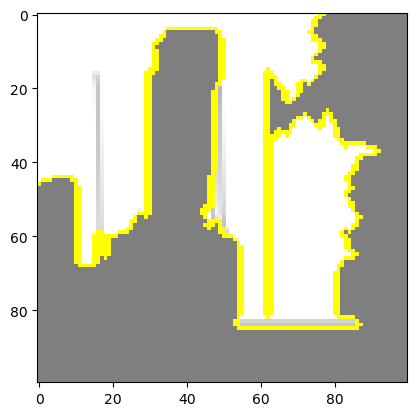

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


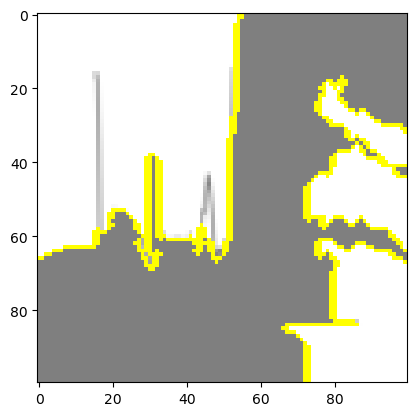

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 65ms/step


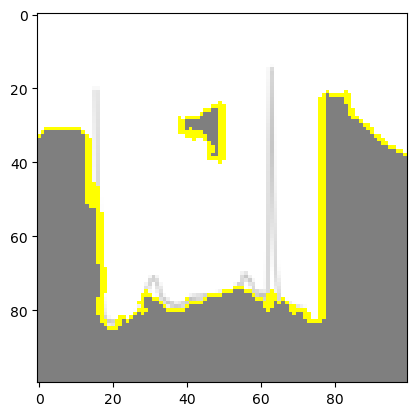

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


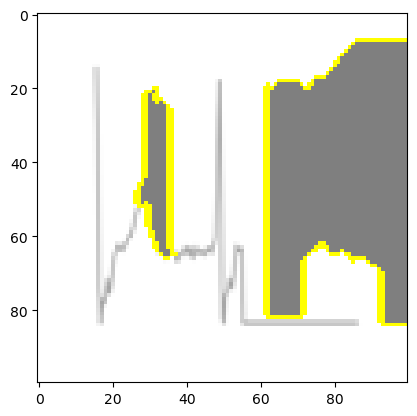

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step


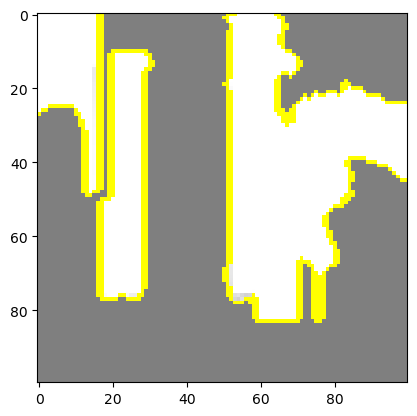

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


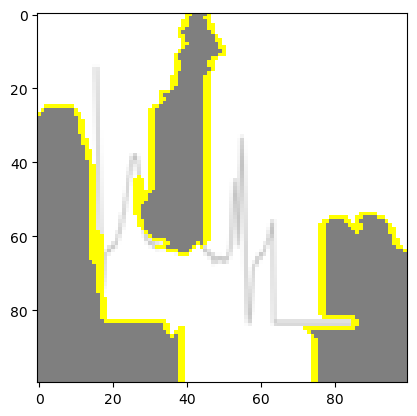

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


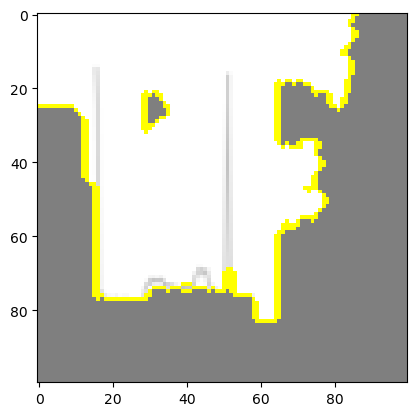

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


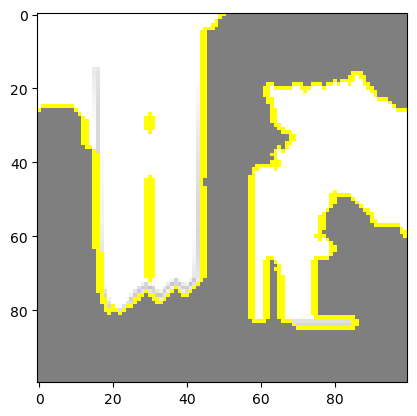

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


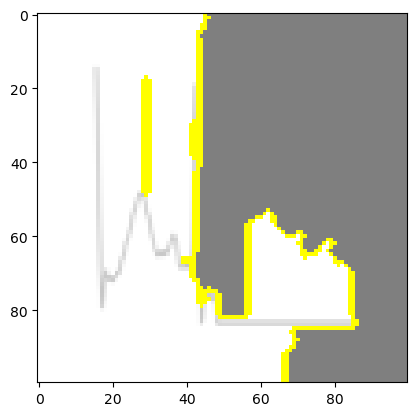

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


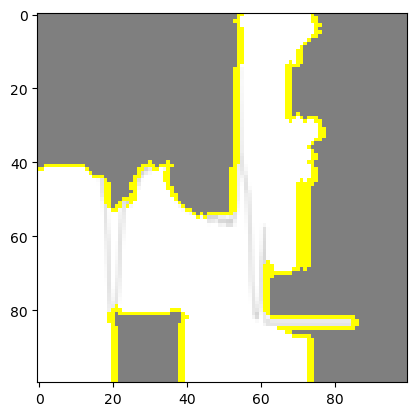

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step


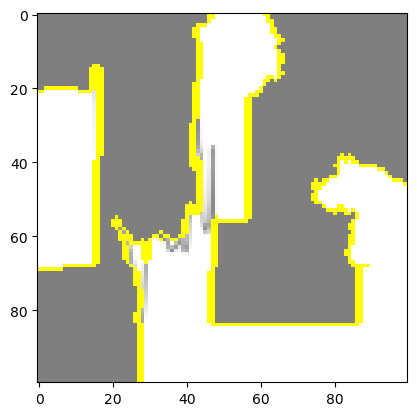

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


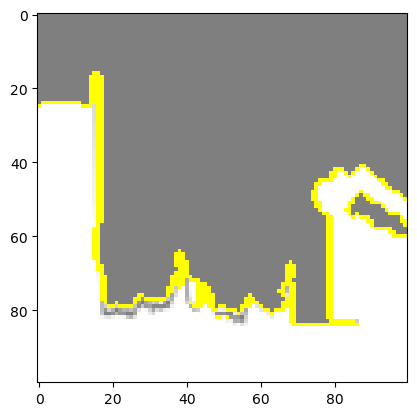

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


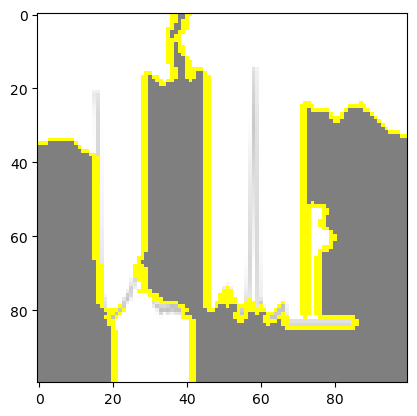

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


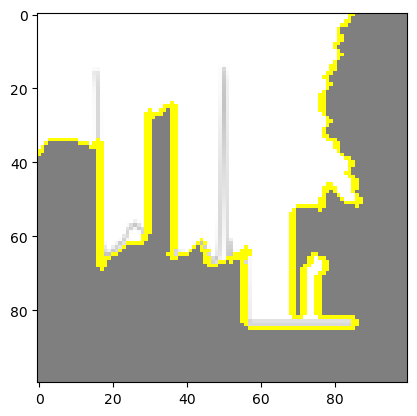

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


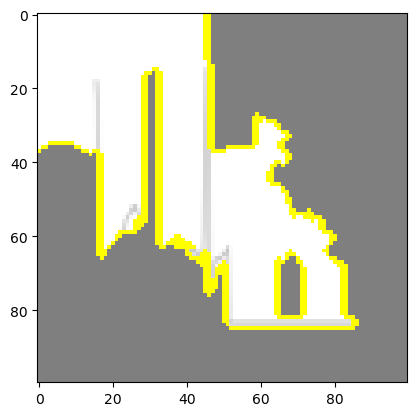

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


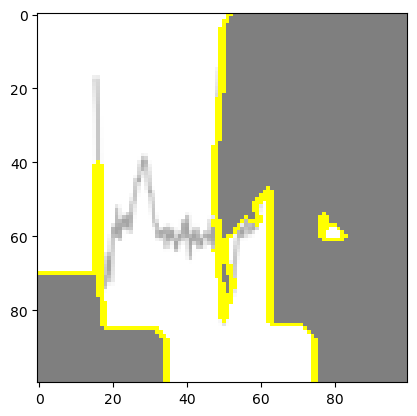

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


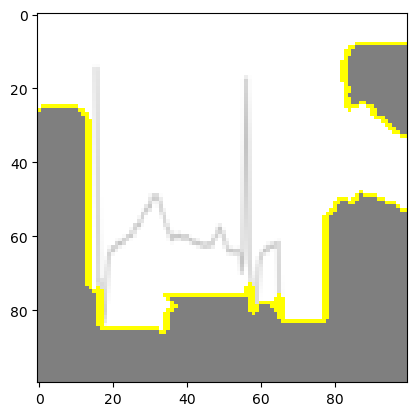

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 57ms/step


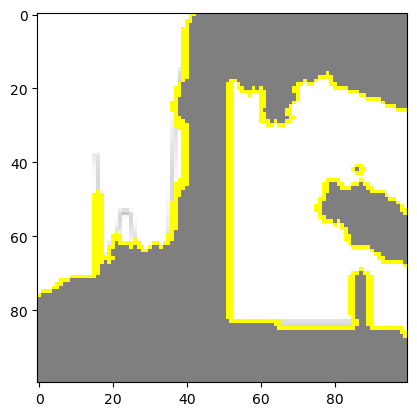

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


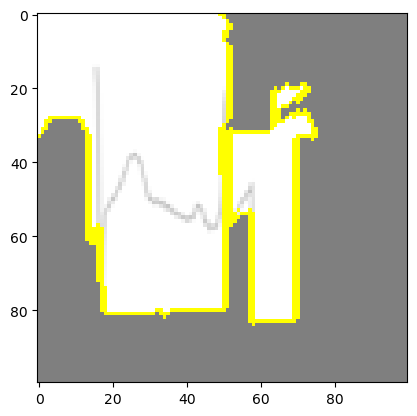

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 67ms/step


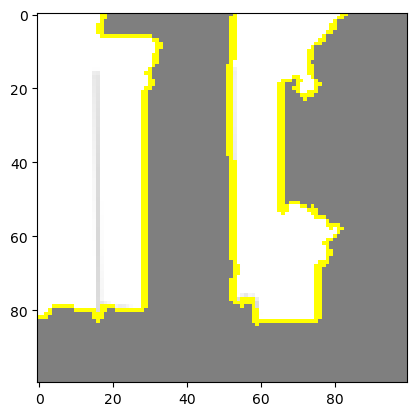

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


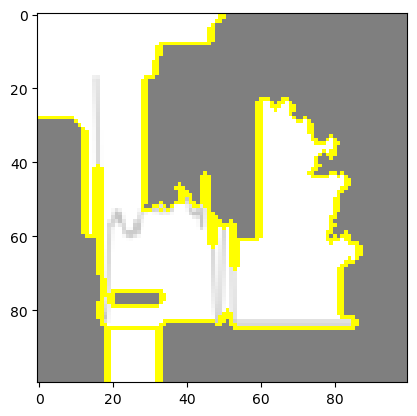

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


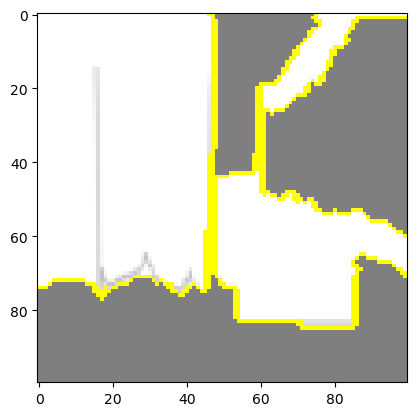

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


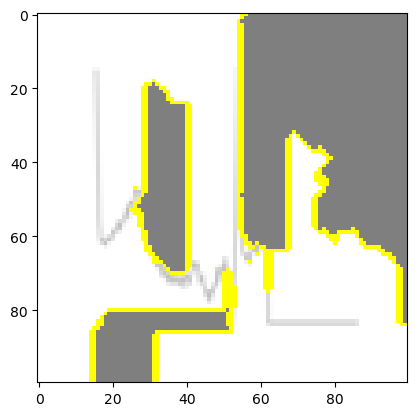

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


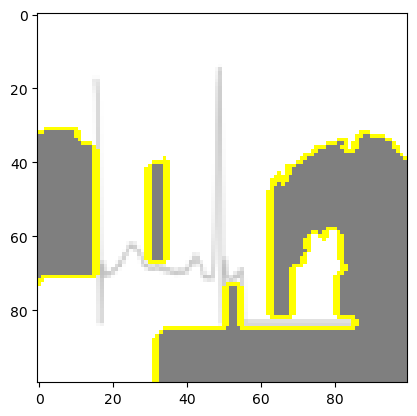

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


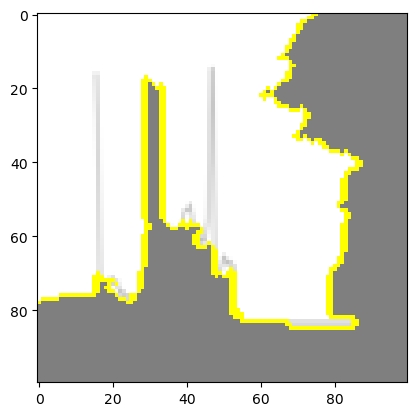

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 67ms/step


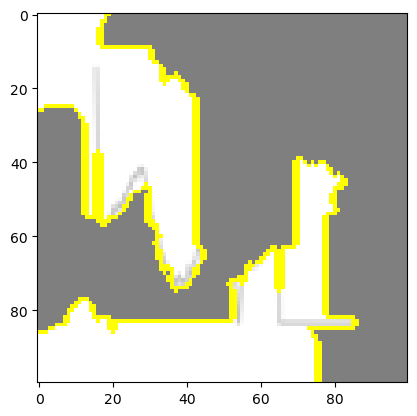

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 57ms/step


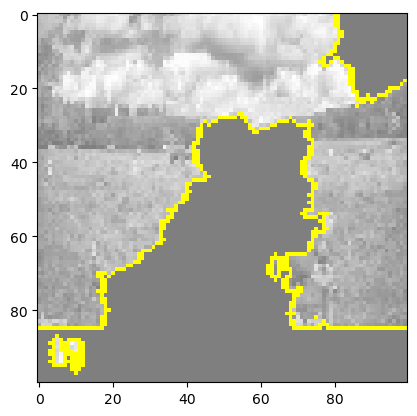

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


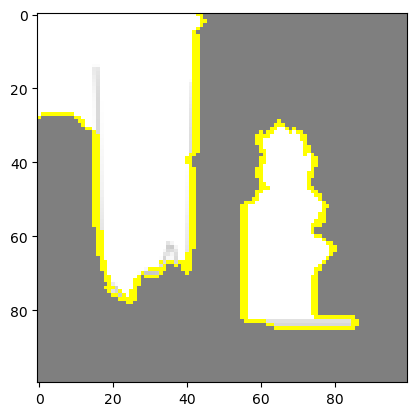

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


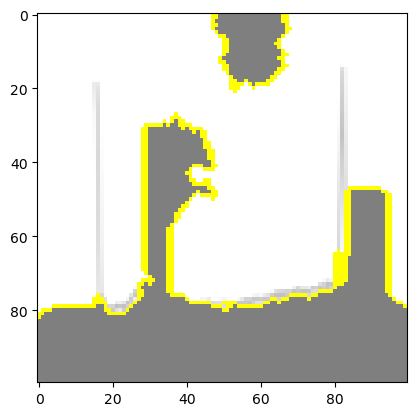

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step


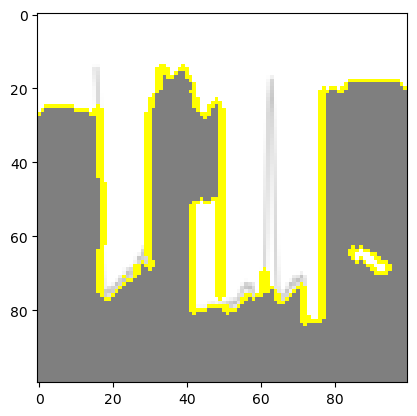

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


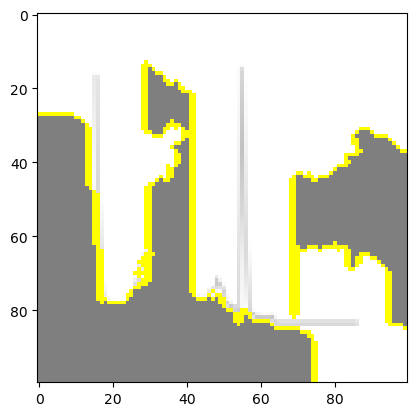

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


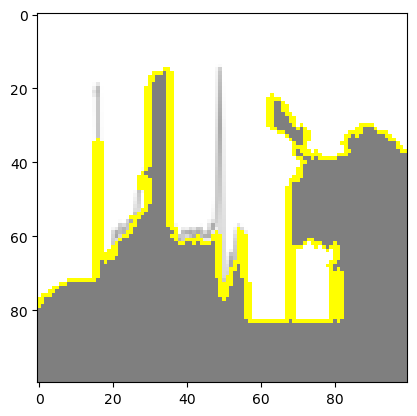

In [2]:
!pip install lime
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Define the path to your dataset
dataset_path = "grayscale_images"

# Define image parameters
image_height, image_width = 100, 100
batch_size = 32

# Function to load and preprocess images using Data Generators
def create_data_generators(dataset_path, batch_size):
    datagen = ImageDataGenerator(rescale=1./255)

    data_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    return data_generator

# Create data generators for training and testing
train_generator = create_data_generators(dataset_path, batch_size)

# Get the number of classes
num_classes = train_generator.num_classes

# Build a DNN model
model = Sequential()
model.add(Flatten(input_shape=(image_height, image_width, 3)))  # Adjust input shape
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=10)

# Save the model
model.save('cow_diseases_detection_model_dnn.h5')

# Load the model
model = load_model('cow_diseases_detection_model_dnn.h5')

# Extract sample images from the data generator
sample_images, sample_labels = train_generator.next()

# Define Lime explainer
explainer = lime_image.LimeImageExplainer()

# Function to predict using the DNN model
def predict_fn(images):
    return model.predict(images)

# Explain predictions
for i in range(len(sample_images)):
    explanation = explainer.explain_instance(sample_images[i], predict_fn, top_labels=5, hide_color=0, num_samples=1000)

    # Display the image and its explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.show()


In [9]:
#dnn

In [11]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
import time

# Function to load and preprocess image data
def load_images_and_labels(data_directory):
    images = []
    labels = []
    label_map = {}  # Dictionary to map folder names to class labels
    
    for i, folder_name in enumerate(os.listdir(data_directory)):
        label_map[folder_name] = i
        folder_path = os.path.join(data_directory, folder_name)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            # Resize the image to a fixed size (e.g., 100x100)
            image = cv2.resize(image, (100, 100))
            images.append(image)
            labels.append(i)  # Use the mapped class label
        
    return np.array(images), np.array(labels)

# Load and preprocess the image data
data_directory = r"C:\\Users\\omhee\\Downloads\\cow-disease\\cow-disease"
X, y = load_images_and_labels(data_directory)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize pixel values to range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Flatten the images
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Record start time
start_time = time.time()

# Define DNN model
model = Sequential([
    Flatten(input_shape=(100, 100, 3)),  # Adjust input shape
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Record end time
end_time = time.time()

# Display results and execution time
print(f'DNN Accuracy: {test_accuracy*100:.2f}')
print(f'Execution time: {end_time - start_time:.2f} seconds')


Epoch 1/10
20/20 [==============================] - 3s 89ms/step - loss: 11.3100 - accuracy: 0.4808 - val_loss: 3.3906 - val_accuracy: 0.5987
Epoch 2/10
20/20 [==============================] - 1s 63ms/step - loss: 1.7756 - accuracy: 0.5417 - val_loss: 1.2593 - val_accuracy: 0.6051
Epoch 3/10
20/20 [==============================] - 1s 65ms/step - loss: 2.0021 - accuracy: 0.5801 - val_loss: 2.2444 - val_accuracy: 0.5541
Epoch 4/10
20/20 [==============================] - 1s 70ms/step - loss: 1.5130 - accuracy: 0.5753 - val_loss: 1.3928 - val_accuracy: 0.6369
Epoch 5/10
20/20 [==============================] - 1s 72ms/step - loss: 0.7279 - accuracy: 0.7452 - val_loss: 1.3822 - val_accuracy: 0.6051
Epoch 6/10
20/20 [==============================] - 2s 78ms/step - loss: 0.9214 - accuracy: 0.6699 - val_loss: 1.7450 - val_accuracy: 0.5669
Epoch 7/10
20/20 [==============================] - 1s 68ms/step - loss: 0.9082 - accuracy: 0.6779 - val_loss: 2.3908 - val_accuracy: 0.5032
Epoch 8/10
2

In [10]:
#ChatBot

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Sample symptoms data with corresponding diseases
symptoms_data = {
    'Coughing, Sneezing, Fever': 'cows_pox',
    'Itchy skin, Hair loss, Skin lesions': 'cows_Mange',
    'Circular patches of hair loss, Scaling, Crusting': 'cows_ringworm',
    'No specific symptoms': 'healthycows',
    'Swelling, Abscesses, Fever': 'lumpycows'
}


import os
import numpy as np
from skimage import io
from skimage.transform import resize

def load_images_and_labels(data_folder):
    images = []
    labels = []

    class_labels = ['cows_Mange', 'cows_pox', 'cows_ringworm', 'healthycows', 'lumpycows']

    for label in class_labels:
        folder_path = os.path.join(data_folder, label)
        if os.path.isdir(folder_path):
            image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
            for image_file in image_files:
                image_path = os.path.join(folder_path, image_file)
                image = io.imread(image_path)
                image = resize(image, (64, 64))  # Resize images to a common size
                images.append(image.flatten())
                labels.append(label)

    return np.array(images), np.array(labels)

# Set your data folder path
data_folder = r"C:\Users\omhee\Downloads\cow-disease"

# Load cow disease images and labels
X, y = load_images_and_labels(data_folder)


# Create TF-IDF vectorizer and transform symptoms data
tfidf_vectorizer = TfidfVectorizer()
X_text = tfidf_vectorizer.fit_transform(symptoms_data.keys())

# Encode target labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(list(symptoms_data.values()))

# Train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_text, y_encoded)

# Function to predict disease from symptoms
def predict_disease(symptoms):
    symptoms_vectorized = tfidf_vectorizer.transform([symptoms])
    disease_label = classifier.predict(symptoms_vectorized)
    predicted_disease = encoder.inverse_transform(disease_label)[0]
    return predicted_disease

# Path to the directory containing images for each disease
# image_dir = r"C:\\Users\\omhee\\Downloads\\cow-disease\\cow-disease"

# Dictionary mapping diseases to their corresponding image file names
disease_images = {
    'cows_Mange': ['mange1.jpg', 'mange2.jpg', 'mange3.jpg'],
    'cows_pox': ['pox1.jpg', 'pox2.jpg', 'pox3.jpg'],
    'cows_ringworm': ['ringworm1.jpg', 'ringworm2.jpg', 'ringworm3.jpg'],
    'healthycows': ['healthy1.jpg', 'healthy2.jpg', 'healthy3.jpg'],
    'lumpycows': ['lumpy1.jpg', 'lumpy2.jpg', 'lumpy3.jpg']
}

# Path to the directory containing images for each disease
image_dir = r"C:\Users\omhee\Downloads\cow-disease\cow-disease\cows_Mange\00000001 (1).jpg"

# Function to display an image corresponding to the predicted disease
def display_image(predicted_disease):
    image_files = disease_images.get(predicted_disease, [])
    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(image_dir, predicted_disease, random_image)
        if os.path.exists(image_path):  # Check if the image file exists
            img = Image.open(image_path)
            plt.imshow(img)
            plt.title("Image of " + predicted_disease)
            plt.axis('off')
            plt.show()
        else:
            print("Image file not found:", image_path)
    else:
        print("No image found for", predicted_disease)



# Example usage
symptoms = "Coughing, Sneezing, Fever': 'cows_pox"
predicted_disease = predict_disease(symptoms)
print("Predicted Disease:", predicted_disease)

# Display corresponding image (if available)
display_image(predicted_disease)

Predicted Disease: cows_pox
Image file not found: C:\Users\omhee\Downloads\cow-disease\cow-disease\cows_Mange\00000001 (1).jpg\cows_pox\pox1.jpg
